In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.metrics import f1_score

In [4]:
import matplotlib.pyplot as plt

In [5]:
import config
from utils.io import load_pickle
from utils.torch.datasets import PathologicalImagesDataset, PathologicalImagesDatasetMode
from utils.scoring import topcoder_metric

# Load dataset

In [6]:
mode = PathologicalImagesDatasetMode.Train
nb_folds = 5
fold_number = 0
base_dir = config.DATASET_TRAIN_DIR

In [7]:
dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)

TypeError: only integer scalar arrays can be converted to a scalar index

In [18]:
images = [dataset[i][0] for i in range(len(dataset))]
masks = [dataset[i][1] for i in range(len(dataset))]

In [19]:
images = np.stack(images)
masks = np.stack(masks)

In [15]:
images.shape, masks.shape

((168, 500, 500, 3), (168, 500, 500))

# Load predictions 

In [140]:
images_filename, predictions = load_pickle(config.PREDICTIONS_DIR.joinpath(f'UNet_480_480_train.pkl'))

In [141]:
predictions.shape

(168, 500, 500)

In [142]:
predictions_mask = np.zeros_like(predictions)
predictions_mask[predictions>0.1] = 1

# Plot predictions

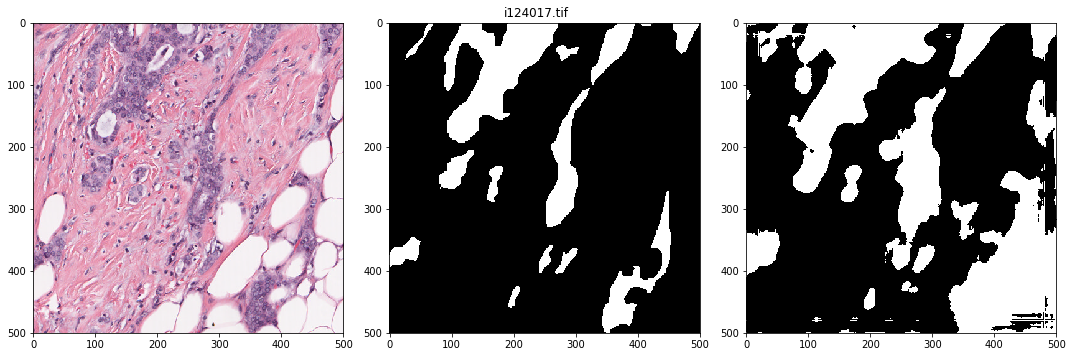

In [143]:
i = 2

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.imshow(images[i])
ax2.imshow(masks[i], cmap='gray')
ax3.imshow(predictions_mask[i], cmap='gray')

fig.suptitle(images_filename[i].name)

fig.tight_layout()

# Get score

In [172]:
def f1_micro_score(y_true, y_pred):
    score = f1_score(y_true.flatten(), y_pred.flatten(), average='micro')
    return score


def dice_score(y_true, y_pred):
    epsilon = 0.000001
    denominator = y_true.sum(axis=(1, 2)) + y_pred.sum(axis=(1, 2)) + epsilon
    numerator = 2 * np.sum(y_true * y_pred, axis=(1, 2)) + epsilon

    dice = numerator / denominator

    dice = dice.mean()
        
    return dice

def topcoder_metric(y_true, y_pred):
    if y_true.max() > 1:
        y_true = y_true / 255
    
    f1 = f1_micro_score(y_true, y_pred)
    print('f1', f1)
    d = dice_score(y_true, y_pred)
    print('dice', d)
    
    score = 1000000.0 * (f1 + d) / 2.0
    print('score', score)
    
    return score

In [173]:
predictions_mask = np.zeros_like(predictions)
predictions_mask[predictions>0.1] = 1

score = topcoder_metric(masks, predictions_mask)

f1 0.864314666667
dice 0.740197802906
score 802256.234786


In [145]:
threshold_data = []
for tr in np.arange(0.1, 1.0, 0.1):
    predictions_mask = np.zeros_like(predictions)
    predictions_mask[predictions>tr] = 1
    
    score = topcoder_metric(masks, predictions_mask)
    
    threshold_data.append({'threshold': tr, 'score': score})

In [146]:
threshold_data = pd.DataFrame(threshold_data)

In [147]:
threshold_data

,score,threshold
0,802256.241617,0.1
1,848708.434600,0.2
2,868913.537407,0.3
3,873807.187824,0.4
4,869745.604239,0.5
5,857631.294572,0.6
6,835190.693216,0.7
7,795044.341580,0.8
8,710173.223025,0.9


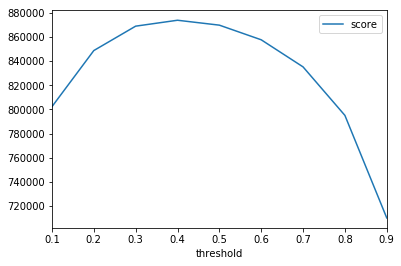

In [148]:
threshold_data.plot(x='threshold', y='score')